# Robotics, Vision & Control 3e: for Python
## Chapter 14: Using Multiple Images

In [1]:
try:
    import google.colab
    print('Running on CoLab')
    !pip install matplotlib
    !pip install machinevision-toolbox-python
    !pip install --no-deps rvc3python
    COLAB = True
except:
    COLAB = False

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
from IPython.core.display import HTML

import RVC3 as rvc
import sys, os.path
sys.path.append(os.path.join(rvc.__path__[0], 'examples'))

import numpy as np
from scipy import linalg, stats
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 14.1 Point Feature Correspondence


In [2]:
view1 = Image.Read("eiffel-1.png", mono=True)
view2 = Image.Read("eiffel-2.png", mono=True)

Image: 1280 x 960 (uint8) [.../images/eiffel-2.png]

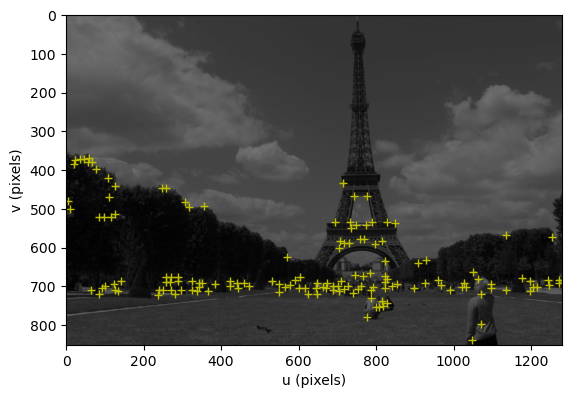

In [3]:
hf = view1.Harris(nfeat=150)
view1.disp(block=None, darken=True); hf.plot();

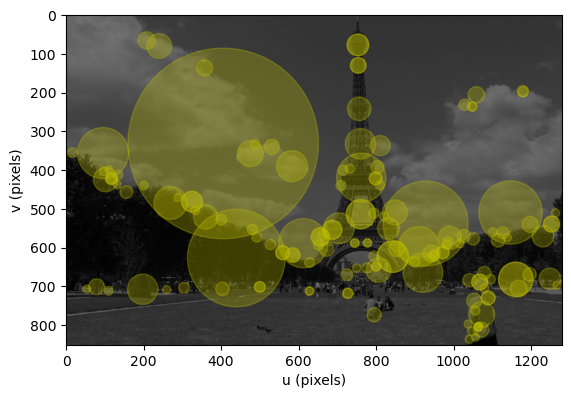

In [4]:
sf = view1.SIFT().sort().filter(minscale=10)[:150]
view1.disp(block=None, darken=True); sf.plot(filled=True, color="y", alpha=0.3)

In [5]:
hf[0].descriptor.shape

(121,)

In [6]:
hf[0].distance(hf[1], metric="ncc")

array([[  0.5908]])

In [7]:
sf[0].descriptor.shape

(128,)

In [8]:
sf[0].distance(sf[1], metric="L2")

array([[   484.1]])

In [9]:
sf1 = view1.SIFT()
sf2 = view2.SIFT()

SIFTFeature features, 3028 points

In [10]:
matches = sf1.match(sf2);
len(matches)

860

In [11]:
matches[:5].list()

  0:    24.00 (1118.6, 178.7) <--> (952.5, 417.9)
  1:    24.12 (900.2, 636.6) <--> (775.6, 802.3)
  2:    25.81 (760.3, 125.0) <--> (656.2, 369.1)
  3:    27.33 (820.5, 519.0) <--> (708.0, 701.6)
  4:    28.12 (801.1, 632.4) <--> (694.1, 800.3)


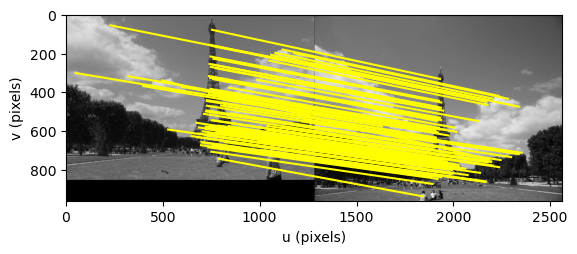

In [12]:
matches.subset(100).plot(color="yellow", block=None)

In [13]:
c = matches.correspondence();
c[:, :5]

array([[2890, 2467, 1661, 2218, 2081],
       [2258, 1945, 1412, 1773, 1705]])

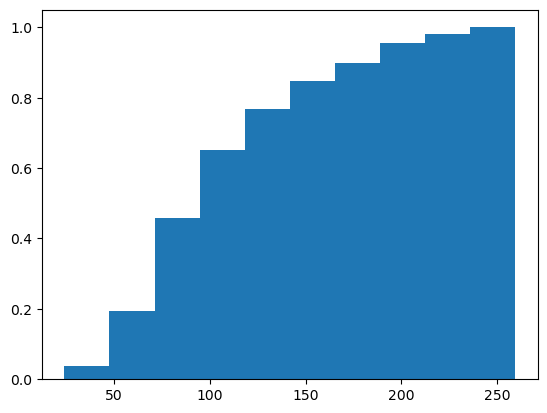

In [14]:
plt.hist(matches.distance, cumulative=True, density=True);

In [15]:
m = sf1.match(sf2, thresh=20);

In [16]:
m = sf1.match(sf2, sort=True)[:10];

In [17]:
m = sf1.match(sf2, ratio=0.8)

951 matches

In [18]:
m = sf1.match(sf2, crosscheck=True)

1372 matches

# 14.2 Geometry of Multiple Views


In [19]:
camera1 = CentralCamera(name="camera 1", f=0.002, imagesize=1000, 
                        rho=10e-6, pose=SE3.Tx(-0.1)*SE3.Ry(0.4))

           Name: camera 1 [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 1000 x 1000
           pose: t = -0.1, 0, 0; rpy/yxz = 0°, 0°, 22.9°
   principal pt: [     500      500]
   focal length: [   0.002    0.002]

In [20]:
camera2 = CentralCamera(name="camera 2", f=0.002, imagesize=1000, 
                        rho=10e-6, pose=SE3.Tx(0.1)*SE3.Ry(-0.4))

           Name: camera 2 [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 1000 x 1000
           pose: t = 0.1, 0, 0; rpy/yxz = 0°, 0°, -22.9°
   principal pt: [     500      500]
   focal length: [   0.002    0.002]

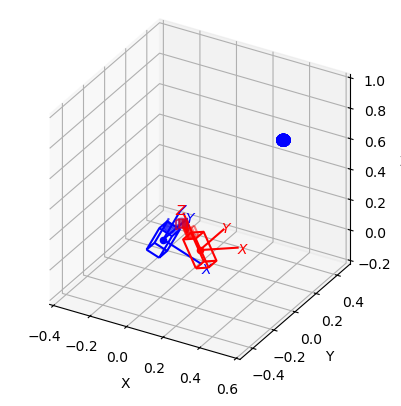

In [21]:
ax = plotvol3([-0.4, 0.6, -0.5, 0.5, -0.2, 1]);
camera1.plot(ax=ax, scale=0.15, shape="camera", frame=True, color="blue");
camera2.plot(ax=ax, scale=0.15, shape="camera", frame=True, color="red");
P=[0.5, 0.1, 0.8];
plot_sphere(0.03, P, color="blue");

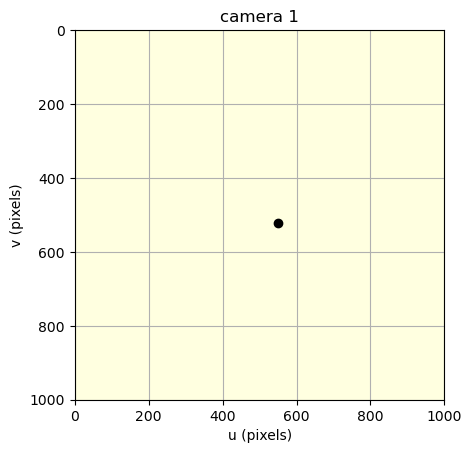

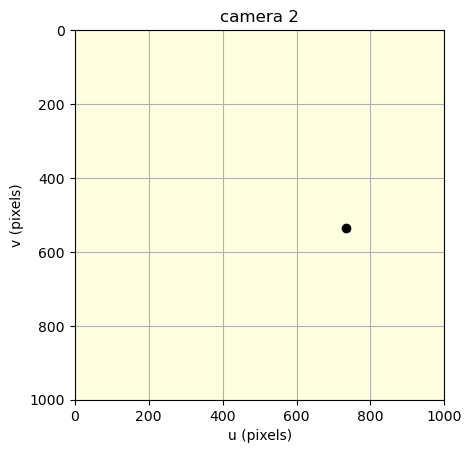

array([[     734],
       [   534.4]])

In [22]:
p1 = camera1.plot_point(P)
p2 = camera2.plot_point(P)

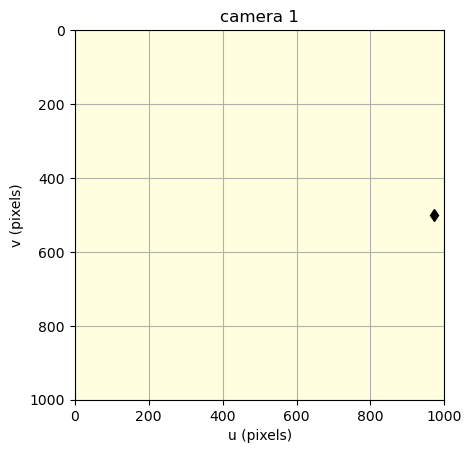

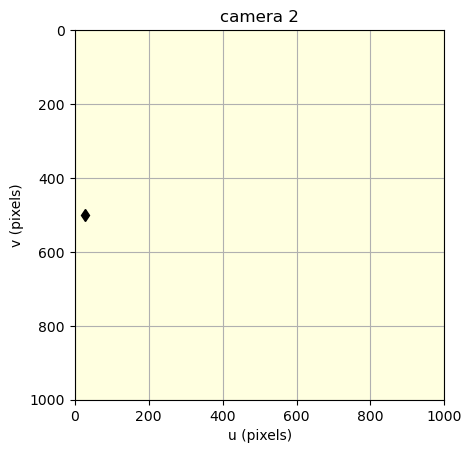

array([[   26.96],
       [     500]])

In [23]:
e1 = camera1.plot_point(camera2.centre, "kd")
e2 = camera2.plot_point(camera1.centre, "kd")

## 14.2.1 The Fundamental Matrix


In [24]:
F = camera1.F(camera2)

array([[       0, -1.947e-06, 0.0009735],
       [-1.947e-06,        0, 0.001895],
       [0.0009735, 5.248e-05,  -0.9735]])

In [25]:
e2h(p2).T @ F @ e2h(p1)

array([[       0]])

In [26]:
np.linalg.matrix_rank(F)

2

In [27]:
e1h = linalg.null_space(F);
e1h.T

array([[ -0.8894,   -0.457, -0.0009141]])

In [28]:
e1 = h2e(e1h)

array([[     973],
       [     500]])

In [29]:
e2h = linalg.null_space(F.T);
e2 = h2e(e2h)

array([[   26.96],
       [     500]])

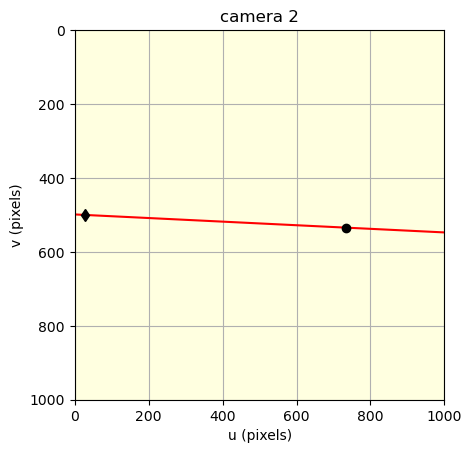

In [30]:
plt.clf()
with plt.ioff():
    camera2.plot_epiline(F, p1, color="red");
    camera2.plot_point(camera1.centre, "kd");  # show the epipole
    camera2.plot_point(P);                     # show the point

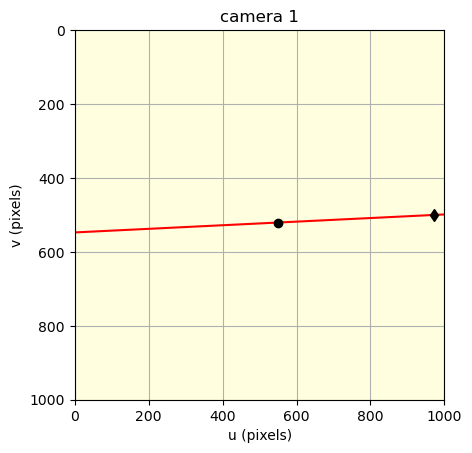

In [31]:
plt.clf()
with plt.ioff():
    camera1.plot_epiline(F.T, p2, color="red");
    camera1.plot_point(camera2.centre, "kd");  # show the epipole
    camera1.plot_point(P);                     # show the point


## 14.2.2 The Essential Matrix


In [32]:
E = camera1.E(F)

array([[       0, -0.07788,        0],
       [-0.07788,        0,   0.1842],
       [       0,  -0.1842,        0]])

In [33]:
T_1_2 = camera1.decomposeE(E);
T_1_2.printline(orient="camera")

t = -0.921, 0, -0.389; rpy/yxz = -180°, 0°, 180°
t = 0.921, 0, 0.389; rpy/yxz = -180°, 0°, 180°
t = -0.921, 0, -0.389; rpy/yxz = 0°, 0°, -45.8°
t = 0.921, 0, 0.389; rpy/yxz = 0°, 0°, -45.8°


In [34]:
T_1_2_true = camera1.pose.inv() * camera2.pose;
T_1_2_true.printline(orient="camera")

t = 0.184, 0, 0.0779; rpy/yxz = 0°, 0°, -45.8°


In [35]:
T_1_2_true.t / np.linalg.norm(T_1_2_true.t)

array([  0.9211,        0,   0.3894])

In [36]:
Q = [0, 0, 10];

In [37]:
camera1.project_point(Q).T

array([[   417.8,      500]])

In [38]:
for T in T_1_2:
 print(camera1.project_point(Q, pose=T).T)

[[     nan      nan]]
[[     nan      nan]]
[[   746.1      500]]
[[     670      500]]


In [39]:
T = camera1.decomposeE(E, Q);
T.printline(orient="camera")

t = -0.921, 0, -0.389; rpy/yxz = 0°, 0°, -45.8°


## 14.2.3 Estimating the Fundamental Matrix from Real Image Data


In [40]:
P = np.random.uniform(low=-1, high=1, size=(3, 10)) + np.c_[0, 0, 3].T;

In [41]:
p1 = camera1.project_point(P);
p2 = camera2.project_point(P);

In [42]:
F, resid = CentralCamera.points2F(p1, p2)
resid

1.3102964018894192e-07

In [43]:
np.linalg.matrix_rank(F)

2

False


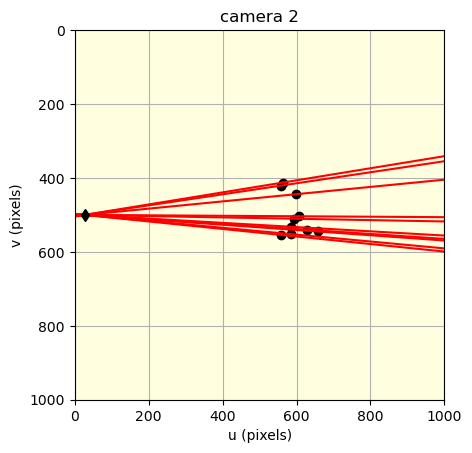

In [44]:
plt.clf()
with plt.ioff():
    camera2.plot_point(P);
    print(plt.isinteractive())
    camera2.plot_epiline(F, p1, color="red")
    camera2.plot_point(camera1.centre, "kd")

In [45]:
p2[:,[5, 6]] = p2[:,[6, 5]];

In [46]:
_, resid = CentralCamera.points2F(p1, p2);
resid

0.007142966331039891

In [47]:
CentralCamera.epidist(F, p1[:, 0], p2[:,0])
CentralCamera.epidist(F, p1[:, 5], p2[:,5])

array([[   34.82]])

In [48]:
F, resid, inliers = CentralCamera.points2F(p1, p2, method="ransac", 
                                           confidence=0.99, seed=0);
resid

1.5402483939476352e-07

In [49]:
inliers

array([ True,  True,  True,  True,  True, False, False,  True,  True,  True])

In [50]:
F, resid, inliers = CentralCamera.points2F(matches.p1, matches.p2, 
                                           method="ransac", confidence=0.99);
resid
sum(inliers) / len(inliers)

0.8244186046511628

In [51]:

sum(~inliers)

151

In [52]:
F, resid = matches.estimate(CentralCamera.points2F, method="ransac", 
                            confidence=0.99, seed=0);

In [53]:
matches
matches[:10].list()

  0:  +  24.00 (1118.6, 178.7) <--> (952.5, 417.9)
  1:  +  24.12 (900.2, 636.6) <--> (775.6, 802.3)
  2:  +  25.81 (760.3, 125.0) <--> (656.2, 369.1)
  3:  +  27.33 (820.5, 519.0) <--> (708.0, 701.6)
  4:  +  28.12 (801.1, 632.4) <--> (694.1, 800.3)
  5:  +  29.33 (1094.0, 184.7) <--> (932.9, 423.0)
  6:  +  31.06 (781.0, 214.4) <--> (672.8, 443.8)
  7:  +  33.60 (1094.0, 184.7) <--> (932.9, 423.0)
  8:  +  33.70 (526.5, 484.2) <--> (462.4, 673.6)
  9:  +  33.79 (759.7, 332.0) <--> (655.9, 543.0)


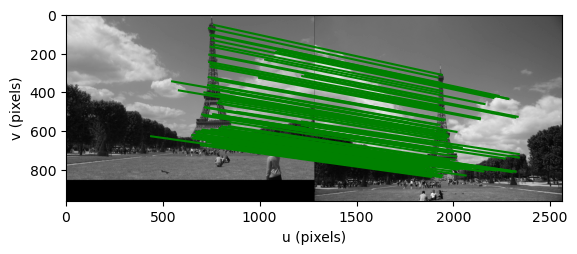

In [54]:
matches.inliers.subset(100).plot(color="g", block=None);

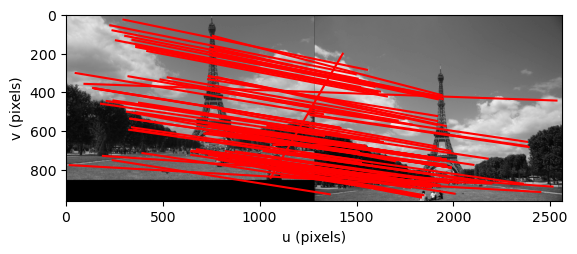

In [55]:
matches.outliers.subset(100).plot(color="red")

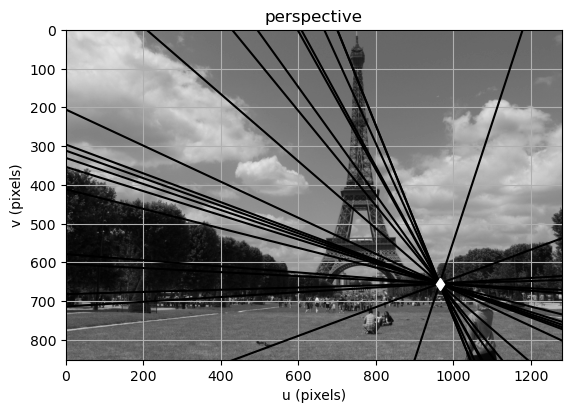

In [56]:
camera = CentralCamera();
with plt.ioff():
    camera.disp(view1, block=None);
    camera.plot_epiline(F.T, matches.inliers.subset(20).p2, color="black");
    epipole = h2e(linalg.null_space(F))
    camera.plot_point(epipole, "wd");
plt.show()

#### Excurse 14.3

[6, 8, 0, 1, 5, 7, 10]

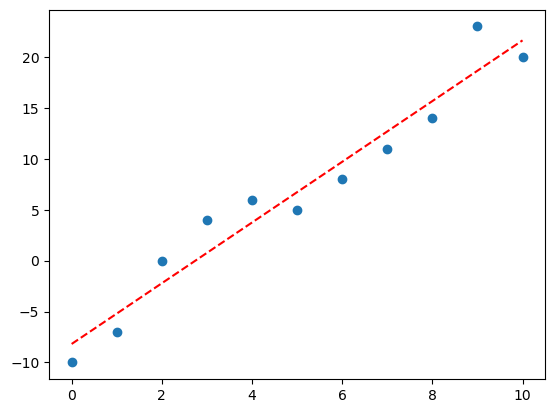

In [57]:
if COLAB:
    !pip install --no-deps rvc3python

from RVC3.examples import ransac_line

x = np.arange(11);
y = 3 * x - 10;
nbad = 4;
np.random.seed(1)  # set the random number generator seed
bad = np.random.choice(len(x), nbad, replace=False)
y[bad] = y[bad] + np.random.rand(nbad) * 10
plt.plot(x, y, 'o')

m, c, *_ = stats.linregress(x, y)
plt.plot(x, m * x + c, 'r--');
params, inliers = ransac_line.ransac_line(x, y)
params
inliers


## 14.2.4 Planar Homography


In [58]:
T_grid = SE3.Tz(1) * SE3.Rx(0.1) * SE3.Ry(0.2);
P = mkgrid(3, 1.0, pose=T_grid);

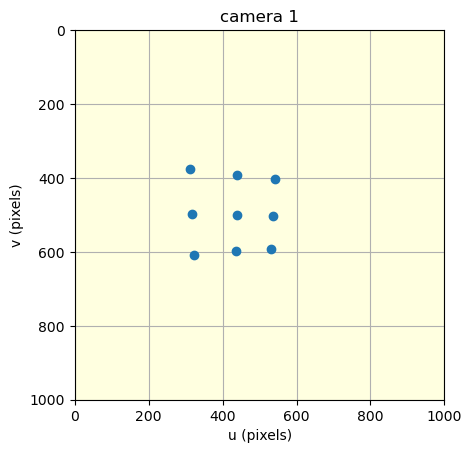

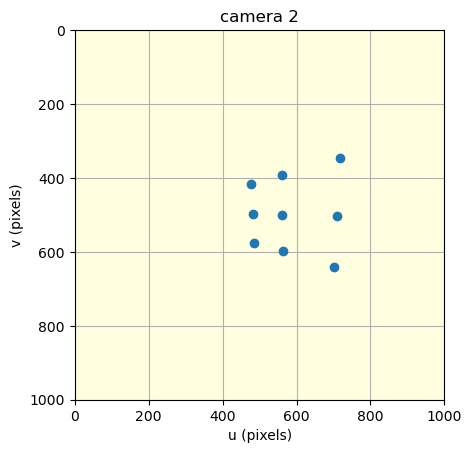

In [59]:
p1 = camera1.plot_point(P, "o");
p2 = camera2.plot_point(P, "o");

In [60]:
H, resid = CentralCamera.points2H(p1, p2)
H

array([[ -0.4187, -0.0003935,    397.8],
       [ -0.6981,   0.3738,    309.5],
       [-0.001396, -1.459e-05,        1]])

In [61]:
p2b = homtrans(H, p1);

In [62]:
with plt.ioff():
    camera2.plot_point(p2b, "+");
    camera2.plot_point(P, "o");  # show original points

In [63]:
p1b = homtrans(np.linalg.inv(H), p1);

In [64]:
Q = np.array([
  [-0.2302,   -0.0545,    0.2537],
  [ 0.3287,    0.4523,    0.6024],
  [ 0.4000,    0.5000,    0.6000] ]);

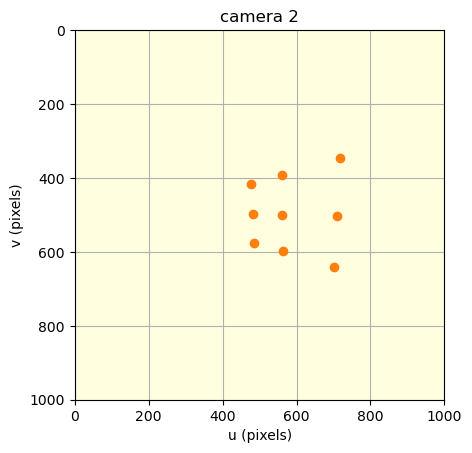

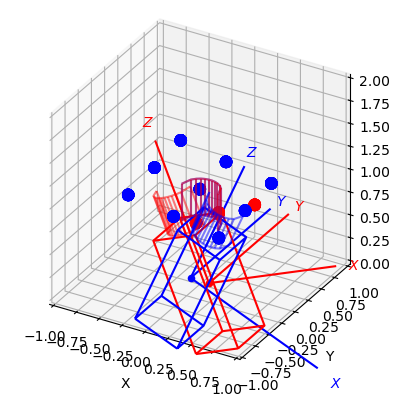

In [65]:
plotvol3([-1, 1, -1, 1, 0, 2]);
plot_sphere(0.05, P, color="blue");
plot_sphere(0.05, Q, color="red");
camera1.plot(color="blue", frame=True);
camera2.plot(color="red", frame=True);

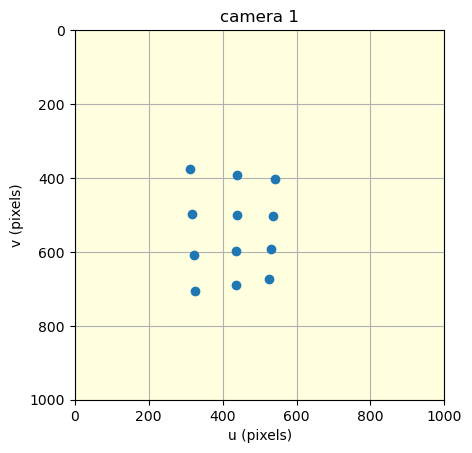

In [66]:
p1 = camera1.plot_point(np.hstack((P, Q)), "o");

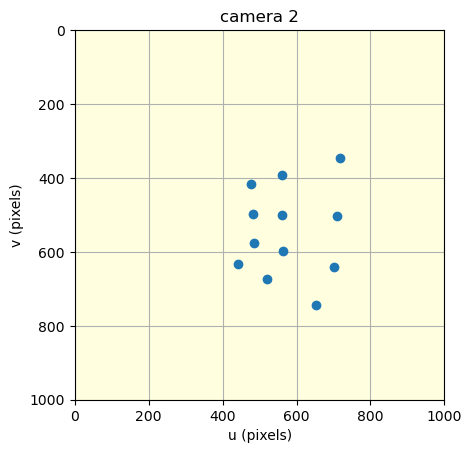

In [67]:
p2 = camera2.plot_point(np.hstack((P, Q)), "o");

In [68]:
p2h = homtrans(H, p1);

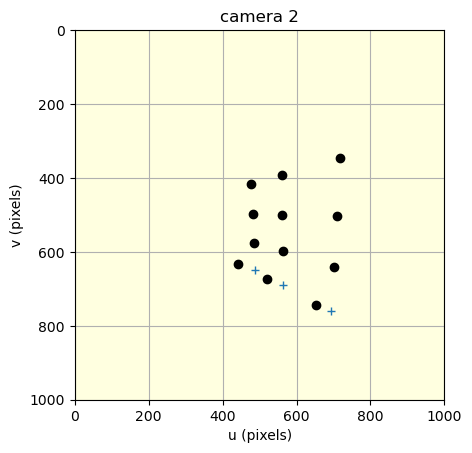

In [69]:
with plt.ioff():
    camera2.plot_point(p2h, "+");
    camera2.plot_point(p2);    # show projected points
plt.show()

In [70]:
np.linalg.norm(homtrans(H, p1) - p2, axis=0)

array([1.262e-05, 9.673e-06, 6.544e-07, 8.302e-06, 4.34e-06, 1.189e-05, 1.679e-05, 5.884e-06, 3.927e-05,     50.6,
          46.44,    45.38])

In [71]:
H, resid, inliers = CentralCamera.points2H(p1, p2, method="ransac");
resid
inliers

array([ True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False])

In [72]:
T, normals = camera1.decomposeH(H);
T.printline(orient="camera")

t = -0.185, 0, -0.0783; rpy/yxz = -8.39e-06°, 4.61e-06°, -45.8°
t = 0.185, 0, 0.0783; rpy/yxz = -8.39e-06°, 4.61e-06°, -45.8°
t = 0.0197, 0.0192, -0.199; rpy/yxz = 1.09°, 0.338°, -34.4°
t = -0.0197, -0.0192, 0.199; rpy/yxz = 1.09°, 0.338°, -34.4°


In [73]:
(camera1.pose.inv() * camera2.pose).printline(orient="camera")

t = 0.184, 0, 0.0779; rpy/yxz = 0°, 0°, -45.8°


In [74]:
camera1.pose.inv() * T_grid

   0.9797   -0.03888  -0.1968   -0.2973    
   0.01983   0.995    -0.09784   0         
   0.1996    0.09195   0.9756    0.96      
   0         0         0         1         


In [75]:
normals[1].T

array([[ -0.1968, -0.09784,   0.9756]])

In [76]:
walls_l = Image.Read("walls-l.png", reduce=2);
walls_r = Image.Read("walls-r.png", reduce=2);

In [77]:
sf_l = walls_l.SIFT();
sf_r = walls_r.SIFT();

In [78]:
matches = sf_l.match(sf_r);

In [79]:
H, resid = matches.estimate(CentralCamera.points2H, confidence=0.9, seed=0)
matches

2797 matches, with 967 (34.6%) inliers

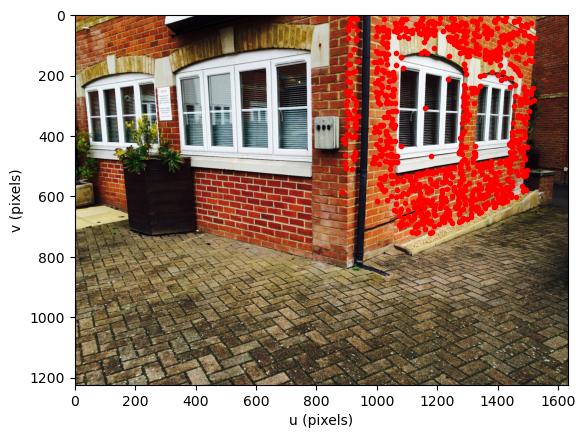

In [80]:
walls_l.disp(block=None);
plot_point(matches.inliers.p1, "r.");

In [81]:
not_plane = matches.outliers;

# 14.3 Sparse Stereo


## 14.3.1 3D Triangulation


In [82]:
matches = sf_l.match(sf_r)
F, resid = matches.estimate(CentralCamera.points2F, confidence=0.99, seed=0);

In [83]:
matches = matches.inliers  # keep only the inliers

2389 matches, with 2389 (100.0%) inliers

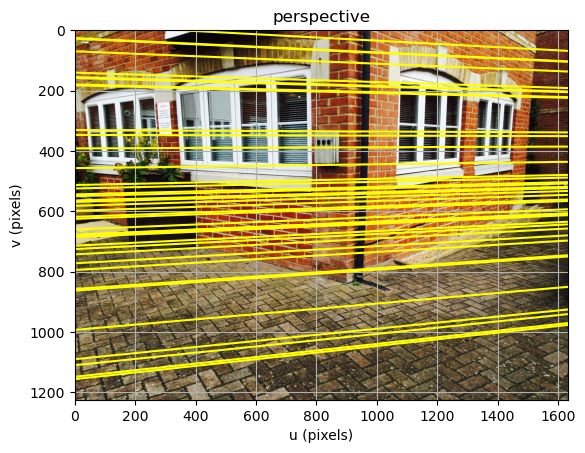

In [84]:
camera = CentralCamera();
camera.disp(walls_l, block=None);
camera.plot_epiline(F.T, matches.subset(40).p2, "yellow");

In [85]:
f = walls_l.metadata("FocalLength")

4.15

In [86]:
name = walls_l.metadata("Model")

'iPhone 5s'

In [87]:
camera = CentralCamera(name=name, imagesize=walls_l.shape, 
                       f=f/1000, rho=2*1.5e-6)

           Name: iPhone 5s [CentralCamera]
     pixel size: 3e-06 x 3e-06
     image size: 1224 x 1632
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [     612      816]
   focal length: [ 0.00415  0.00415]

In [88]:
E = camera.E(F)

array([[ -0.1101,   -10.08,   -2.762],
       [   9.457,   0.7444,   -44.71],
       [   2.845,    45.03,    1.149]])

In [89]:
T_1_2 = camera.decomposeE(E, [0, 0, 10]);
T_1_2.printline(orient="camera")

t = -0.976, 0.0669, -0.205; rpy/yxz = -0.441°, 1.28°, 0.716°


In [90]:
t = T_1_2.t;
s = 0.3 / t[0]  # estimate of translation scale factor
T_1_2.t = s * t  # scaled translation
T_1_2.printline(orient="camera")

t = 0.3, -0.0206, 0.0631; rpy/yxz = -0.441°, 1.28°, 0.716°


In [91]:
ray1 = camera.ray(matches[0].p1)

{ 0 0 0; 0.45053 -0.43771 1}

In [92]:
ray2 = camera.ray(matches[0].p2, pose=T_1_2)

{ -0.0071757 0.27523 0.12379; 0.3282 -0.43513 0.98647}

In [93]:
P, e = ray1.closest_to_line(ray2);
P

array([   1.066,   -1.036,    2.367])

In [94]:
e

0.0006718430761685473

In [95]:
ray1 = camera.ray(matches.p1);
ray2 = camera.ray(matches.p2, pose=T_1_2);

In [96]:
len(ray1)

2389

In [97]:
P, e = ray1.closest_to_line(ray2);
P.shape

(3, 2389)

In [98]:
z = P[2, :];
z.mean()

2.2336901958654543

In [99]:
np.median(e)
e.max()

0.024741940113809393

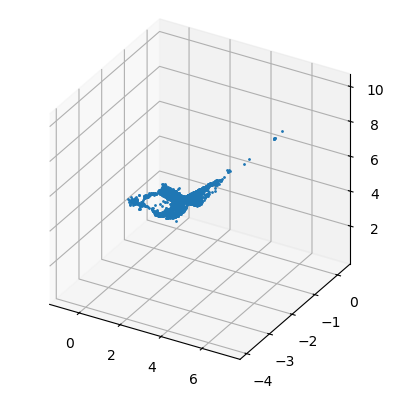

In [100]:
plotvol3();
plt.plot(P[0,:], P[1,:], P[2,:], '.', markersize=2);

In [101]:
if not COLAB:
    walls_pcd = PointCloud(P)
    walls_pcd.transform(SE3.Rx(pi));  # make y-axis upward
    walls_pcd.disp(block=True)
    walls_pcd = walls_pcd.remove_outlier(nb_points=10, radius=0.2)

In [102]:
if not COLAB:
  colors = []
  for m in matches:
    colors.append(walls_l.image[int(m.p1[1]), int(m.p1[0]), :])
  pcd = SE3.Rx(pi) * PointCloud(P, colors=np.array(colors).T)
  pcd.disp(block=True)

In [103]:
p1_reproj = camera.project_point(P[:, 0]);
p2_reproj = camera.project_point(P[:, 0], pose=T_1_2);

In [104]:
(p1_reproj - matches[0].p1).T
(p2_reproj - matches[0].p2).T

array([[-0.06476,   -804.6],
       [   804.9,   0.4298]])

In [105]:
bundle = BundleAdjust(camera);

In [106]:
view0 = bundle.add_view(SE3(), fixed=True);
view1 = bundle.add_view(SE3.Tx(0.3));

In [107]:
for (Pj, mj) in zip(P[:, ::4].T, matches[::4]):
  landmark = bundle.add_landmark(Pj)             # add vertex
  bundle.add_projection(view0, landmark, mj.p1)  # add edge
  bundle.add_projection(view1, landmark, mj.p2)  # add edge

In [108]:
bundle

Bundle adjustment problem:  2 views
    1 locked views: [0]
  598 landmarks
  1196 projections
  1806 total states
  1800 variable states
  2392 equations
  landmarks per view: min=598, max=598, avg=598.0
  views per landmark: min=2, max=2, avg=2.0

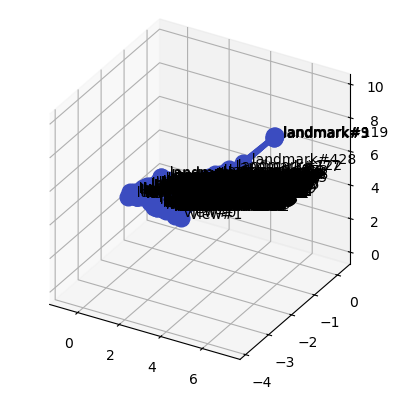

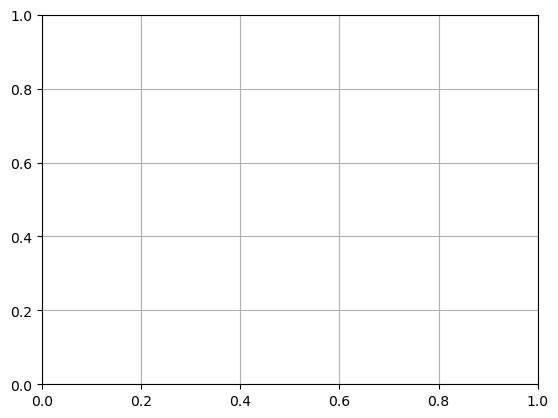

In [109]:
bundle.plot()

In [110]:
x = bundle.getstate();
x.shape

(1806,)

In [111]:
x[6:12]

array([     0.3,        0,        0,        0,        0,        0])

In [112]:
x[12:15]

array([   1.066,   -1.036,    2.367])

In [113]:
bundle.errors(x)

1460212.3827897187

p, A, B = camera.derivatives(t, r, P);

In [114]:
x_new, resid = bundle.optimize(x);

Bundle adjustment cost 1.46e+06 -- initial
Bundle adjustment cost 3.42e+03 (solved in 1.18 sec)
Bundle adjustment cost 293 (solved in 1.18 sec)
Bundle adjustment cost 289 (solved in 1.18 sec)
Bundle adjustment cost 289 (solved in 1.18 sec)
Bundle adjustment cost 289 (solved in 1.18 sec)
Bundle adjustment cost 289 (solved in 1.21 sec)

 * 6 iterations in 7.4 seconds
 * Final RMS error is 0.49 pixels


In [115]:
bundle.setstate(x_new);

In [116]:
bundle.views[1].pose.printline(orient="camera")

t = 0.365, -0.0302, 0.0852; rpy/yxz = -0.601°, 1.27°, 0.117°


In [117]:
T_1_2.printline(orient="camera")

t = 0.3, -0.0206, 0.0631; rpy/yxz = -0.441°, 1.28°, 0.716°


In [118]:
bundle.landmarks[0].P

array([   1.066,   -1.036,    2.367])

In [119]:
e = np.sqrt(bundle.getresidual());
e.shape

(2, 598)

In [120]:
np.median(e, axis=1)

array([  0.3014,    0.295])

In [121]:
np.max(e, axis=1)

array([   2.107,    1.984])

# 14.4 Dense Stereo Matching


In [122]:
rocks_l = Image.Read("rocks2-l.png", reduce=2)
rocks_r = Image.Read("rocks2-r.png", reduce=2)

Image: 638 x 555 (uint8), R:G:B [.../images/rocks2-r.png]

rocks_l.stdisp(rocks_r)

In [123]:
disparity, *_ = rocks_l.stereo_simple(rocks_r, hw=3, drange=[40, 90]);

/home/vicentamen/miniconda3/envs/RVC3/lib/python3.10/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/vicentamen/miniconda3/envs/RVC3/lib/python3.10/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


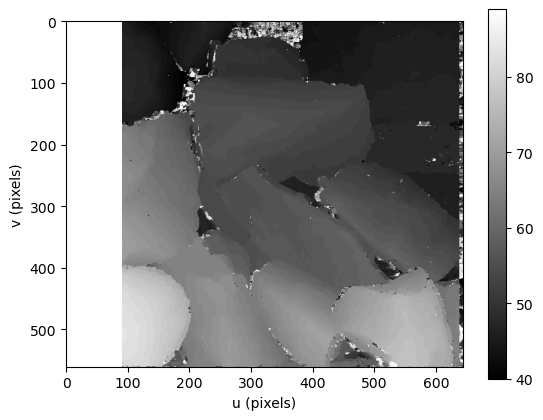

In [124]:
disparity.disp(colorbar=True);

In [125]:
disparity, similarity, DSI = rocks_l.stereo_simple(rocks_r, hw=3, drange=[40, 90])

In [126]:
DSI.shape

(561, 644, 50)

In [127]:
np.argmax(DSI, axis=2);

In [128]:
similarity_values = np.max(DSI, axis=2);

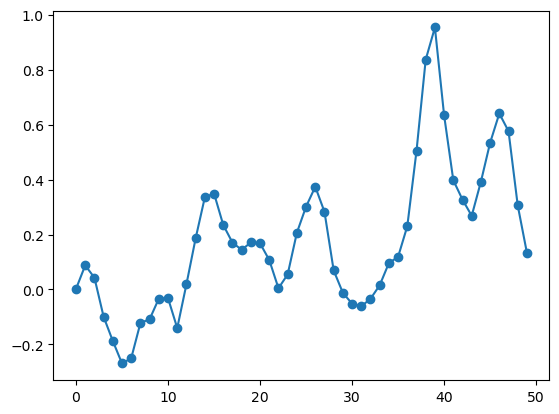

In [129]:
plt.plot(DSI[439, 138, :], "o-");

## 14.4.1 Peak Refinement


In [130]:
disparity_refined, A = Image.DSI_refine(DSI)

## 14.4.2 Stereo Failure Modes


### 14.4.2.1 Multiple peaks


### 14.4.2.2 Weak matching


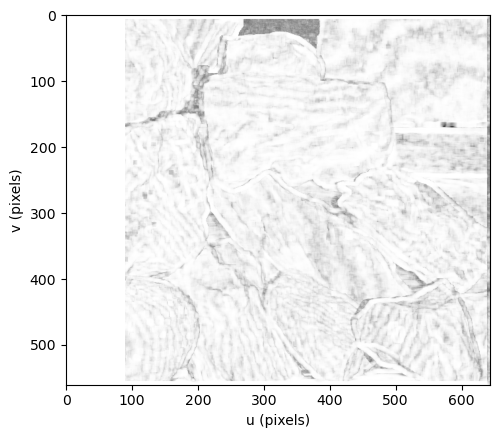

In [131]:
similarity.disp();

/home/vicentamen/miniconda3/envs/RVC3/lib/python3.10/site-packages/machinevisiontoolbox/ImageCore.py:235: UserWarning: defaulting color to RGB
  warnings.warn("defaulting color to RGB")
/home/vicentamen/miniconda3/envs/RVC3/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


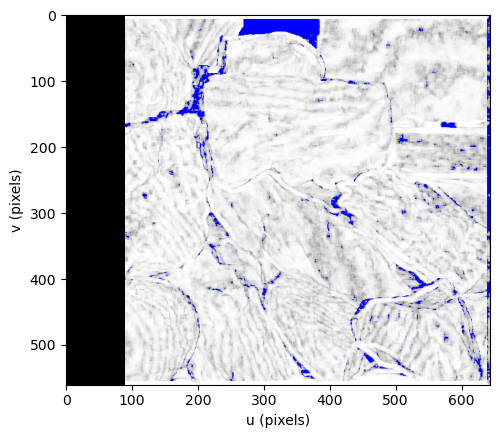

In [132]:
similarity.choose("blue", similarity < 0.6).disp();

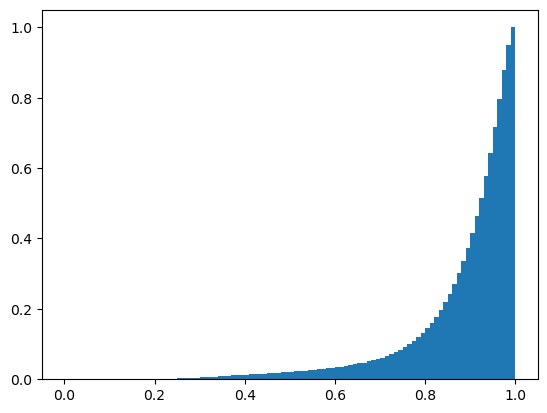

In [133]:
plt.hist(similarity.view1d(), 100, (0, 1), cumulative=True, density=True);

### 14.4.2.3 Broad peak


### 14.4.2.4 Quantifying Failure Modes


In [134]:
status = np.ones(disparity.shape);

In [135]:
U, V = disparity.meshgrid()
status[np.isnan(disparity.image)] = 5   # no similarity computed
status[U <= 90] = 2                     # no overlap
status[similarity.image < 0.6] = 3      # weak match
status[A.image >= -0.1] = 4             # broad peak

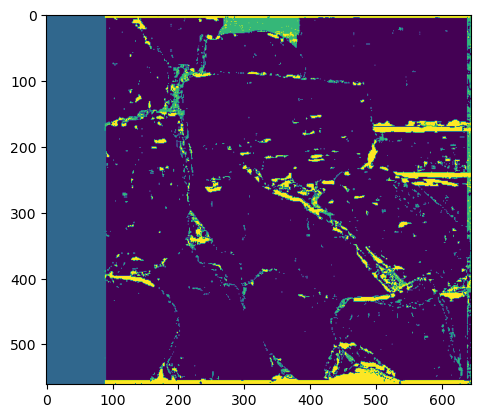

In [136]:
plt.imshow(status);

In [137]:
(status == 1).sum() / status.size * 100

76.99427597125806

In [138]:
disparity_valid = disparity.choose(0, status!=1)

Image: 644 x 561 (float32)

### 14.4.2.5 Slicing the DSI


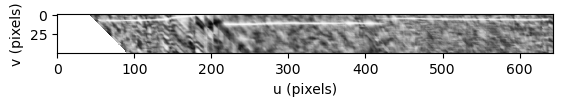

In [139]:
Image(DSI[100, :, :].T).disp();

### 14.4.2.6 Summary


### 14.4.2.7 Advanced Stereo Matching


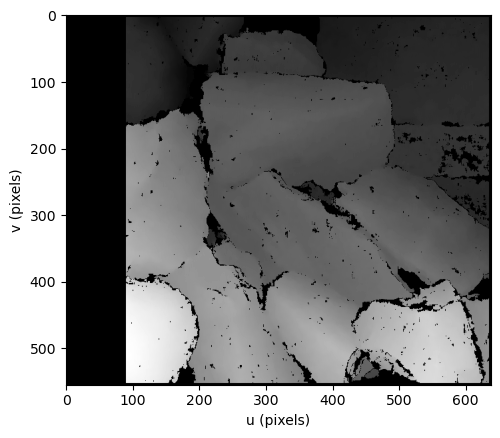

In [140]:
disparity_BM = rocks_l.stereo_BM(rocks_r, hw=3, drange=[40, 90], speckle=(200, 2))
disparity_BM.disp();

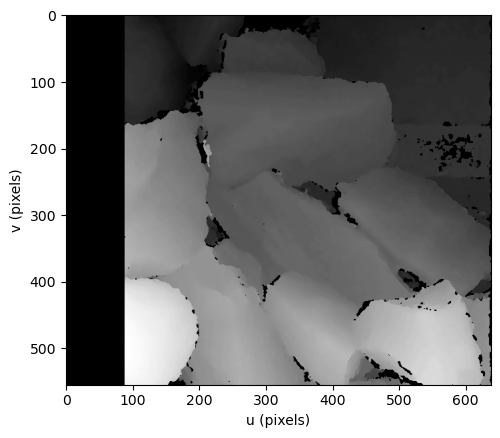

In [141]:
rocks_l.stereo_SGBM(rocks_r, hw=3, drange=[40, 90], speckle=(200, 2)).disp();

### 14.4.2.8 3D Reconstruction


In [142]:
di = disparity_BM.image * 2 + 274;

In [143]:
U, V = disparity_BM.meshgrid();
u0, v0 = disparity.centre;
f = 3740;   # pixels, according to Middlebury website
b = 0.160;  # m, according to Middlebury website
X = b * (U - u0) / di; Y = b * (V - v0) / di; Z = f * b / di;

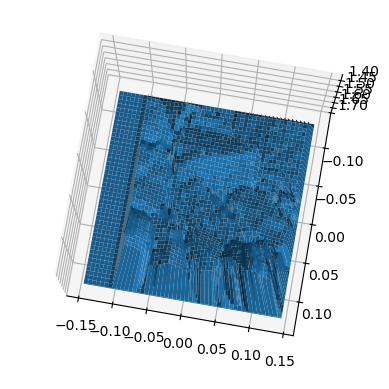

In [144]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z)
ax.view_init(-100, -100)

In [145]:
if not COLAB:
    cam = CentralCamera(f=f, imagesize=rocks_l.shape);
    pcd = PointCloud(Z, image=rocks_l, camera=cam, depth_trunc=1.9)
    pcd *= SE3.Rx(pi);  # make y-axis upward
    pcd.disp(block=True)

RuntimeError: Image can only be initialized from a contiguous buffer.

## 14.4.3 Image Rectification


In [ ]:
walls_l = Image.Read('walls-l.png', reduce=2)
walls_r = Image.Read('walls-r.png', reduce=2)

In [ ]:
sf_l = walls_l.SIFT()
sf_r = walls_r.SIFT()

In [ ]:
matches = sf_l.match(sf_r);

In [ ]:
F, resid = matches.estimate(CentralCamera.points2F, 
                            method="ransac", confidence=0.95);

In [ ]:
H_l, H_r = walls_l.rectify_homographies(matches, F)

In [ ]:
walls_l_rect = walls_l.warp_perspective(H_l)
walls_r_rect = walls_r.warp_perspective(H_r)

In [ ]:
if COLAB:
    walls_l_rect.disp()
    walls_r_rect.disp()
else:
    walls_l_rect.stdisp(walls_r_rect)

In [ ]:
walls_l_rect.stereo_SGBM(walls_r_rect, hw=7, drange=[180, 530], speckle=(50, 2)).disp();

# 14.5 Anaglyphs


In [ ]:
walls_l.anaglyph(walls_r, "rc").disp();

# 14.7 Point Clouds


In [ ]:
if not COLAB:
    bunny_pcd = PointCloud.Read('data/bunny.ply')
    bunny_pcd.disp(block=True)
    pcd = bunny_pcd.voxel_grid(voxel_size=0.01).disp(block=True)
    pcd = bunny_pcd.downsample_voxel(voxel_size=0.01)
    pcd.normals(radius=0.1, max_nn=30)
    pcd.disp(block=True)

## 14.7.1 Fitting a Plane


In [ ]:
if not COLAB:
    pcd = walls_pcd
    # plane, plane_pcd, pcd = pcd.segment_plane(distance_threshold=0.05, seed=0)
    plane, plane_pcd, pcd = pcd.segment_plane(distance_threshold=0.05)
    print(plane)

    print(plane_pcd)

    # plane, plane_pcd, pcd = pcd.segment_plane(distance_threshold=0.05, seed=0)
    plane, plane_pcd, pcd = pcd.segment_plane(distance_threshold=0.05)
    print(plane)

## 14.7.2 Matching Two Sets of Points


In [ ]:
if not COLAB:
    model = bunny_pcd.downsample_random(0.1, seed=0)

    data = SE3.Trans(0.3, 0.4, 0.5) * SE3.Rz(50, unit="deg") * bunny_pcd.downsample_random(0.05, seed=-1);

    model.paint([0, 0, 1])  # blue
    data.paint([1, 0, 0])   # red
    (model + data).disp(block=True)

    T, status = model.ICP(data, max_correspondence_distance=1, 
                    max_iteration=2000, relative_fitness=0, relative_rmse=0)
    T.printline()

    (model + T.inv() * data).disp(block=True)

# 14.8 Applications


## 14.8.1 Perspective Correction


In [ ]:
notredame = Image.Read("notre-dame.png");
notredame.disp();

In [ ]:
# this won't work with Jupyter, use the pre-picked points defined in the next cell
# picked_points = plt.ginput(4);
# p1 = np.array(picked_points).T;

In [ ]:
# coordinates of 4 points that mark the corners of a rectangle on the face of
# the building
p1 = np.array([
        [ 44.1364,   94.0065,  537.8506,  611.8247], 
        [377.0654,  152.7850,  163.4019,  366.4486]]);

In [ ]:
notredame.disp(block=None);
plot_polygon(p1, filled=True, color="y", alpha=0.4, linewidth=2);
plot_point(p1, "yo");
mn = p1.min(axis=1);
mx = p1.max(axis=1);
p2 = np.array([[mn[0], mn[0], mx[0], mx[0]], [mx[1], mn[1], mn[1], mx[1]]]);
plot_polygon(p2, "k--", close=True, linewidth=2);

In [ ]:
H, _ = CentralCamera.points2H(p1, p2, method="leastsquares")
H

In [ ]:
notredame.warp_perspective(H).disp();

In [ ]:
f = notredame.metadata("FocalLength")

In [ ]:
cam = CentralCamera(imagesize=notredame.shape, f=f/1000, sensorsize=[7.18e-3, 5.32e-3])

In [ ]:
pose, normals = cam.decomposeH(H)
pose.printline(orient="camera")

In [ ]:
normals[0].T

## 14.8.2 Image Mosaicing


In [ ]:
images = ImageCollection("mosaic/aerial2-*.png", mono=True);

In [ ]:
composite = Image.Zeros(2_000, 2_000)

In [ ]:
composite.paste(images[0], (0, 0));
composite.disp();

In [ ]:
next_image = images[1]
sf_c = composite.SIFT()
sf_next= next_image.SIFT()
match = sf_c.match(sf_next);

In [ ]:
H, _ = match.estimate(CentralCamera.points2H, "ransac", confidence=0.99);
H

In [ ]:
tile, topleft, corners = next_image.warp_perspective(H, inverse=True, tile=True)

In [ ]:
composite.paste(tile, topleft, method="blend");
composite.disp();

## 14.8.3 Visual Odometry


In [ ]:
import mvtbdata.mvtb_load_image_data

left = ZipArchive("bridge-l.zip", filter="*.pgm", mono=True, dtype="uint8", 
                  maxintval=4095, roi=[20, 750, 20, 480]);
len(left)

In [ ]:
import mvtbdata.mvtb_load_image_data

In [ ]:
if not COLAB:  # simple animations do not work properly in Jupyter
  for image in left:
    #image.disp(reuse=True, block=None)
    image.disp(reuse=True, fps=10, title="bridge-l", matplotlib=False)
  cv_destroy_window("bridge-l")

<div class="note">

The commented out code produces an animation for a Python script, however, using Jupyter it produces a set of separate images.  Use OpenCV instead (`matplotlib=False`) to display the animation in a separate window.
</div>

In [ ]:
for image in left:
   features = image.ORB(nfeatures=20)         # compute ORB features
   image = image.colorize()                   # create RGB image
   features.draw2(image, color='y');          # render ORB features into image
   # image.disp(reuse=True, fps=20, matplotlib=False) # display the image
   # features.plot()                          # overlay the features
   # pause(0.05)

   features.draw2(image, color='y');          # render ORB features into image
   image.disp(reuse=True, fps=20, matplotlib=False) # display the image

In [ ]:
right = ZipArchive("bridge-r.zip", mono=True, dtype="uint8", 
                   maxintval=4095, roi=[20, 750, 20, 480]);

In [ ]:
%run -m visodom

In [ ]:
ts = np.loadtxt(left.open("timestamps.dat"));

In [ ]:
plt.plot(np.diff(ts));